In [1]:
import requests
import json

import pymongo
import numpy as np
import matplotlib.pyplot as plt

from time import sleep
import re
import torch
import os
from scipy.signal import stft
import random
import numpy as np
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import time
import torch.utils.data
from torch.nn.utils.rnn import pad_sequence

In [2]:
print(torch.__version__)


1.4.0+cu100


In [3]:
cou = 655058

In [4]:
EOS_voc = cou + 1
vocab_word_size = cou + 2
max_length = 150
teacher_forcing_p = 0.8
max_words_c = 30
max_word_l = 16

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
print(device)

cuda


In [7]:
print("A")

A


In [8]:
n_epochs = 10
vec_size = 512
vocab_ngram_size = 35
starting_lr = 1e-3

In [9]:
class CharGRU(nn.Module):
    def __init__(self, hidden_size, char_vocab_size):
        super(CharGRU, self).__init__()
        self.gru = nn.GRU(char_vocab_size, hidden_size, batch_first=True)
        self.mask = torch.ones((1, 1, 35))
        self.mask[0][0][0] = 0
        self.mask = self.mask.to(device)

    def forward(self, X):
        x_o = F.one_hot(X, num_classes=35)
        x_o = self.mask * x_o
        _, finstate = self.gru(x_o)
        del _
        return finstate

In [10]:
class NRNN(nn.Module):
    def __init__(self, hidden_size, char_vocab_size, output_size, n_layers=1, dropout_p=0):
        super(NRNN, self).__init__()
        self.hidden_size = hidden_size
        self.chargru = CharGRU(hidden_size, char_vocab_size)
        self.lstm = nn.GRU(hidden_size, hidden_size, num_layers=n_layers, batch_first=True, dropout=dropout_p, bidirectional=True)
        #self.out = nn.Linear(hidden_size * 2, output_size)
        self.out = nn.AdaptiveLogSoftmaxWithLoss(hidden_size * 2, output_size, cutoffs=[3000, 20000, 100000], div_value=4.0)
    def forward(self, x, targets, mask):
        X = x.view((x.shape[0] * x.shape[1], x.shape[2]))
        X = self.chargru(X)
        X = X.view(x.shape[:2] + (-1,))
        lstm_outputs, _ = self.lstm(X)
        lstm_outputs = lstm_outputs.reshape(lstm_outputs.shape[0] * lstm_outputs.shape[1], lstm_outputs.shape[2])
        out, _ = self.out(lstm_outputs, targets)
        #lstm_outputs = self.out(lstm_outputs)
        #lstm_outputs = torch.view(x.shape[:2] + (-1,))
        return -torch.sum(out * mask)
    def predict(self, x):
        X = x.view((x.shape[0] * x.shape[1], x.shape[2]))
        X = self.chargru(X)
        X = X.view(x.shape[:2] + (-1,))
        lstm_outputs, _ = self.lstm(X)
        lstm_outputs = lstm_outputs.reshape(lstm_outputs.shape[0] * lstm_outputs.shape[1], lstm_outputs.shape[2])
        out = self.out.predict(lstm_outputs)
        return out

In [11]:
rev_dict = torch.load("source_files/rev_dict")

In [12]:
rev_dict[EOS_voc]

1

In [13]:
fileind = 12

In [14]:
vec_size

512

In [15]:
w2i_dict = torch.load("source_files/word_2_ind_dict")
i2w = dict()
for i in w2i_dict.keys():
    i2w[w2i_dict[i]] = i

In [16]:
rev_rev_dict = dict()
for i in rev_dict.keys():
    rev_rev_dict[rev_dict[i]] = i

In [17]:
for_dict = dict()
for i in rev_dict.keys():
    if (i != 0):
        if (i == 1):
            for_dict[i] = 'EOS'
        else:
            for_dict[i] = i2w[rev_rev_dict[i] - 1]

In [18]:
values = dict()

In [19]:
for k in for_dict.keys():
    word = for_dict[k]
    if (len(word) >= 16):
        values[k] = torch.tensor([36] * 16, dtype=torch.uint8)
        continue
    if (word == 'EOS'):
        values[k] = torch.tensor([34] * 16, dtype=torch.uint8)
    else:
        ret = []
        for i in range(16 - len(word) - 1):
            ret.append(0)
        for i in word:
            ret.append(ord(i) - ord('а') + 1)
        ret.append(33)
        values[k] = torch.tensor(ret, dtype=torch.uint8)
        del ret

In [20]:
def is_equal(word_letters, word_idx):
    word = values[word_idx.data.item()]
    return torch.all(torch.eq(word, word_letters))

In [21]:
sepstat = open("eval/total_res", "wt", buffering=1)

In [22]:
import datetime
def my_eval(a, b, start_a, fin_b, model):
    mistakes_dict = [0] * (vocab_word_size + 3)
    #loss_f = nn.CrossEntropyLoss(reduction='none').to(device)
    print(datetime.datetime.now())

    new_batch_size = 64
    #sched = optim.lr_scheduler.CosineAnnealingLR(opt, DATA_LENGTH)
    tbegin = time.time()
    modt = 0
    accuracy_b = []
    last_train_loss = 0
    last_test_loss = 0
    batch_n = 0
    cou_total = 0
    cou_mistakes = 0
    cou_first_word_mistakes = 0
    correct_sents = 0
    total_sents = 0
    cou_wrong = 0
    cou_changed = 0
    cou_tp = 0
    for file_idx in range(a, b + 1):
        local_batch_n = 0
        my_data_from_file = torch.load(f"source_files/data_1024_ixy_{file_idx}")
        for is_test, x1, y1 in my_data_from_file:
            if (file_idx == a and local_batch_n < start_a):
                local_batch_n += 1
                continue
            if (file_idx == b and local_batch_n >= fin_b):
                break
            local_batch_n += 1
            if (is_test == 0):
                continue
            for batch_ind in range((len(y1) - 1) // new_batch_size + 1):
                x = x1[batch_ind * new_batch_size : batch_ind * new_batch_size + new_batch_size]
                y = y1[batch_ind * new_batch_size : batch_ind * new_batch_size + new_batch_size]
                target = pad_sequence([torch.tensor([rev_dict[i.data.item()] for i in j]) for j in y], batch_first=True)
                mask = (target != 0)
                batch_n += 1
                tt = time.time()
                x_inp = pad_sequence(x, batch_first=True).long().to(device)
                target_inp = target.view(-1).to(device)
                maskinp = mask.view(-1).to(device)
                out = model.predict(x_inp)
                out_r = out.reshape(target.shape).cpu()
                for i in range(len(target)):
                    for j in range(len(target[i])):
                        if (target[i][j] == 0):
                            continue
                        if not is_equal(x[i][j], target[i][j]):
                            cou_wrong += 1
                            if (out_r[i][j] == target[i][j]):
                                cou_tp += 1
                        if not is_equal(x[i][j], out_r[i][j]):
                            cou_changed += 1
                del out_r
                correct_sents += torch.sum(torch.sum(((target_inp == out).double() * maskinp).reshape(target.shape), dim=1) == torch.sum((maskinp).reshape(target.shape), dim=1))
                total_sents += len(y)
                cou_mistakes += torch.sum((target_inp == out).double() * maskinp)
                cou_total += torch.sum(maskinp)
                accuracy = torch.sum((target_inp == out).double() * maskinp) / torch.sum(maskinp)
                cou_first_word_mistakes += torch.sum((out.reshape(target.shape)[:, 0] != target_inp.reshape(target.shape)[:, 0]).double())
                accuracy_b.append(accuracy.data.item())
                del x_inp
                del target_inp
                del maskinp
                modt += time.time() - tt
                if (file_idx == 7 and (local_batch_n == 2192 or local_batch_n == 2193)):
                    print(f"Correctly changed: {cou_tp}\t Wrong words: {cou_wrong}\t Changes made: {cou_changed}", file=sepstat)
                if (file_idx == 10 and (local_batch_n == 623 or local_batch_n == 624)):
                    print(f"Correctly changed: {cou_tp}\t Wrong words: {cou_wrong}\t Changes made: {cou_changed}", file=sepstat)
                if (file_idx == 11 and (local_batch_n == 2192 or local_batch_n == 2193)):
                    print(f"Correctly changed: {cou_tp}\t Wrong words: {cou_wrong}\t Changes made: {cou_changed}", file=sepstat)
                if (batch_n % (100 * 2048 // new_batch_size) == 0):
                    print('Batch: [{}]\t Accuracy: {}, Time: {}, Model Time: {}'.format(batch_n, np.array(accuracy_b[-(100 * 2048 // new_batch_size):]).mean(), time.time() - tbegin, modt))
        del my_data_from_file
    return accuracy_b, cou_mistakes, cou_total, correct_sents, total_sents, cou_tp, cou_wrong, cou_changed, mistakes_dict

In [23]:
model = torch.load("512ASmodel1layergru_epoch_4.pt")
accuracy_b_tot, cou_mistakes_tot, cou_total_tot, correct_sents_tot, total_sents_tot, cou_tp_tot, cou_wrong_tot, cou_changed_tot, mistakes_dict_tot = my_eval(0, 11, 0, 10**10, model)
del model
torch.save(list((accuracy_b_tot, cou_mistakes_tot, cou_total_tot, correct_sents_tot, total_sents_tot, cou_tp_tot, cou_wrong_tot, cou_changed_tot, mistakes_dict_tot)), "eval/total_eval")
print(cou_tp_tot / cou_changed_tot, cou_tp_tot / cou_wrong_tot)

2020-06-12 15:30:53.973239
Batch: [3200]	 Accuracy: 0.9022107862815915, Time: 370.2608685493469, Model Time: 187.83137226104736
Batch: [6400]	 Accuracy: 0.9014448788757692, Time: 566.047878742218, Model Time: 374.8845462799072
Batch: [9600]	 Accuracy: 0.8968113603522255, Time: 938.8767771720886, Model Time: 563.5634608268738
Batch: [12800]	 Accuracy: 0.9041615638012054, Time: 1130.9335787296295, Model Time: 746.991176366806
Batch: [16000]	 Accuracy: 0.9039532976196075, Time: 1499.288335800171, Model Time: 932.2760238647461
Batch: [19200]	 Accuracy: 0.9002356766262455, Time: 1695.0901985168457, Model Time: 1118.916543006897
Batch: [22400]	 Accuracy: 0.9024319838842598, Time: 1892.052134513855, Model Time: 1306.5607402324677
Batch: [25600]	 Accuracy: 0.902787442182347, Time: 2267.184116125107, Model Time: 1490.0874531269073
Batch: [28800]	 Accuracy: 0.900358073997726, Time: 2463.247430086136, Model Time: 1676.9428856372833
Batch: [32000]	 Accuracy: 0.901664555788397, Time: 2835.286498546

NameError: name 'cou_wrong_rel' is not defined

In [24]:
torch.save(list((accuracy_b_tot, cou_mistakes_tot, cou_total_tot, correct_sents_tot, total_sents_tot, cou_tp_tot, cou_wrong_tot, cou_changed_tot, mistakes_dict_tot)), "eval/total_eval")
print(cou_tp_tot / cou_changed_tot, cou_tp_tot / cou_wrong_tot)

0.7047021385357675 0.8037172008588439


In [27]:
correct_sents_tot.data.item() / total_sents_tot

0.47412573309008343

In [35]:
cou_total_tot

tensor(53984125, device='cuda:0')

In [25]:
sepstat.close()

In [ ]:
model = torch.load("Religionv1_512ASmodel1layergru_epoch_12.pt")
accuracy_b_rel, cou_mistakes_rel, cou_total_rel, correct_sents_rel, total_sents_rel, cou_tp_rel, cou_wrong_rel, cou_changed_rel, mistakes_dict_rel = my_eval(0, 7, 0, 2193, model)
del model
torch.save(list((accuracy_b_rel, cou_mistakes_rel, cou_total_rel, correct_sents_rel, total_sents_rel, cou_tp_rel, cou_wrong_rel, cou_changed_rel, mistakes_dict_rel)), "eval/religion_eval")
print(datetime.datetime.now())
print(cou_tp_rel / cou_changed_rel, cou_tp_rel / cou_wrong_rel)

2020-06-12 01:32:20.334839
Batch: [3200]	 Accuracy: 0.9413438912941423, Time: 363.0086407661438, Model Time: 185.7116630077362
Batch: [6400]	 Accuracy: 0.9425411834229703, Time: 557.0231454372406, Model Time: 370.81741404533386
Batch: [9600]	 Accuracy: 0.9375570111062979, Time: 927.7576763629913, Model Time: 557.0673182010651
Batch: [12800]	 Accuracy: 0.9429768098890048, Time: 1118.0867674350739, Model Time: 738.1487064361572
Batch: [16000]	 Accuracy: 0.9411737365731918, Time: 1492.68527841568, Model Time: 920.7872598171234
Batch: [19200]	 Accuracy: 0.9418739215598052, Time: 1687.275090932846, Model Time: 1105.9747858047485
Batch: [22400]	 Accuracy: 0.9447430143726571, Time: 1883.188233613968, Model Time: 1292.3244285583496
Batch: [25600]	 Accuracy: 0.9414333177109628, Time: 2253.750529527664, Model Time: 1473.9606223106384
Batch: [28800]	 Accuracy: 0.9419256105307656, Time: 2446.8339760303497, Model Time: 1657.7344551086426
Batch: [32000]	 Accuracy: 0.9412679948377288, Time: 2816.1278

In [29]:
accuracy_b_rel, cou_mistakes_rel, cou_total_rel, correct_sents_rel, total_sents_rel, cou_tp_rel, cou_wrong_rel, cou_changed_rel, mistakes_dict_rel = torch.load("eval/religion_eval")

In [30]:
correct_sents_rel.data.item() / total_sents_rel

0.6323418950260264

In [24]:
model = torch.load("Oppositionv7_512ASmodel1layergru_epoch_20.pt")
accuracy_b_opp, cou_mistakes_opp, cou_total_opp, correct_sents_opp, total_sents_opp, cou_tp_opp, cou_wrong_opp, cou_changed_opp, mistakes_dict_opp = my_eval(10, 11, 625, 10**10, model)
del model
torch.save(list((accuracy_b_opp, cou_mistakes_opp, cou_total_opp, correct_sents_opp, total_sents_opp, cou_tp_opp, cou_wrong_opp, cou_changed_opp, mistakes_dict_opp)), "eval/opposition_eval")
print(datetime.datetime.now())
print(cou_tp_opp / cou_changed_opp, cou_tp_opp / cou_wrong_opp)

2020-06-12 01:07:33.386500
Batch: [3200]	 Accuracy: 0.9448392881168977, Time: 370.2704758644104, Model Time: 202.4089126586914
Batch: [6400]	 Accuracy: 0.9419721980810164, Time: 749.1915810108185, Model Time: 409.78500413894653
Batch: [9600]	 Accuracy: 0.9460966326835014, Time: 963.1221034526825, Model Time: 613.9687979221344
Batch: [12800]	 Accuracy: 0.9459092405029749, Time: 1175.8737406730652, Model Time: 817.0364170074463
2020-06-12 01:27:22.697024
0.8276299226636644 0.8579431029426141


In [31]:
accuracy_b_opp, cou_mistakes_opp, cou_total_opp, correct_sents_opp, total_sents_opp, cou_tp_opp, cou_wrong_opp, cou_changed_opp, mistakes_dict_opp = torch.load("eval/opposition_eval")


In [32]:
correct_sents_opp.data.item() / total_sents_opp

0.6229582378443079

In [22]:
model = torch.load("Gardening_512ASmodel1layergru_epoch_18.pt")
accuracy_b_gar, cou_mistakes_gar, cou_total_gar, correct_sents_gar, total_sents_gar, cou_tp_gar, cou_wrong_gar, cou_changed_gar, mistakes_dict_gar = my_eval(7, 10, 2193, 625, model)
del model
torch.save(list((accuracy_b_gar, cou_mistakes_gar, cou_total_gar, correct_sents_gar, total_sents_gar, cou_tp_gar, cou_wrong_gar, cou_changed_gar, mistakes_dict_gar)), "eval/gardening_eval")
print(datetime.datetime.now())
print(cou_tp_gar / cou_changed_gar, cou_tp_gar / cou_wrong_gar)

2020-06-12 00:14:44.984435
Batch: [3200]	 Accuracy: 0.9575756283533662, Time: 543.8192458152771, Model Time: 194.53423690795898
Batch: [9600]	 Accuracy: 0.9582558602423512, Time: 1113.2708921432495, Model Time: 572.6590132713318
Batch: [12800]	 Accuracy: 0.957376736671165, Time: 1312.9485864639282, Model Time: 763.1530973911285
Batch: [16000]	 Accuracy: 0.9572736242578489, Time: 1511.521559715271, Model Time: 952.5858352184296
2020-06-12 00:45:34.706963
0.872862776806757 0.874670432467439


In [33]:
accuracy_b_gar, cou_mistakes_gar, cou_total_gar, correct_sents_gar, total_sents_gar, cou_tp_gar, cou_wrong_gar, cou_changed_gar, mistakes_dict_gar = torch.load("eval/gardening_eval")

In [34]:
correct_sents_gar.data.item() / total_sents_gar

0.7227073328544886

In [40]:
import pandas as pd

In [41]:
from scipy.ndimage.filters import gaussian_filter1d

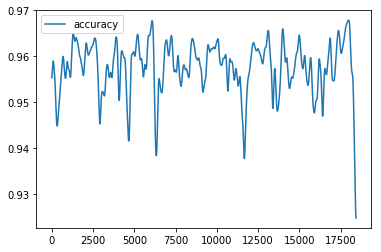

In [42]:
pd.DataFrame(gaussian_filter1d(np.array(accuracy_b_rel), sigma=50), columns=['accuracy']).plot(y='accuracy', kind='line')

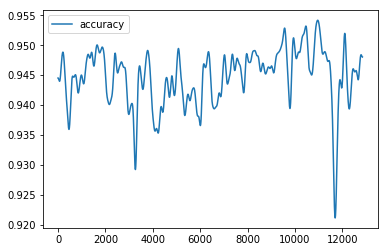

In [43]:
pd.DataFrame(gaussian_filter1d(np.array(accuracy_b_opp), sigma=50), columns=['accuracy']).plot(y='accuracy', kind='line')

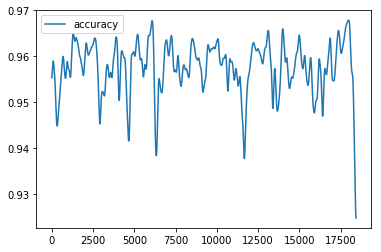

In [44]:
pd.DataFrame(gaussian_filter1d(np.array(accuracy_b_gar), sigma=50), columns=['accuracy']).plot(y='accuracy', kind='line')

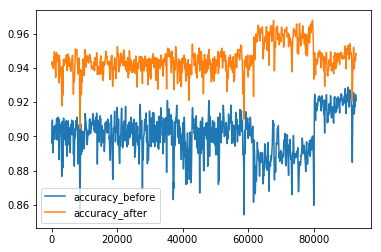

In [53]:
ax = pd.DataFrame(gaussian_filter1d(np.array(accuracy_b_tot), sigma=50), columns=['accuracy_before']).plot(y='accuracy_before', kind='line')
pd.DataFrame(gaussian_filter1d(np.array(accuracy_b_rel + accuracy_b_gar + accuracy_b_opp), sigma=50), columns=['accuracy_after']).plot(y='accuracy_after', kind='line', ax=ax)

In [55]:
np.array(accuracy_b_rel).mean()

0.9419921533799485

In [56]:
np.array(accuracy_b_gar).mean()

0.9576193800351875

In [57]:
np.array(accuracy_b_opp).mean()

0.9447112131086636

In [58]:
np.array(accuracy_b_tot).mean()

0.9012287135953333

In [59]:
print(cou_tp_tot / cou_changed_tot, cou_tp_tot / cou_wrong_tot)

0.7047021385357675 0.8037172008588439


In [66]:
2/(1/0.875 + 1/0.873)

0.8739988558352403

In [61]:
print(cou_tp_rel / cou_changed_rel, cou_tp_rel / cou_wrong_rel)

0.827479284482149 0.844045555199937


In [63]:
print(cou_tp_opp / cou_wrong_opp, cou_tp_opp / cou_changed_opp)

0.8579431029426141 0.8276299226636644


In [65]:
print(cou_tp_gar / cou_wrong_gar, cou_tp_gar / cou_changed_gar)

0.874670432467439 0.872862776806757
